In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.mixture import GaussianMixture

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
sub = pd.read_csv("../input/sample_submission.csv")

print(train.shape, test.shape, sub.shape)

# data = np.array_split(train, train.shape[0] / 500000)
# data_test = np.array_split(test, test.shape[0] / 500000)

(5000000, 3) (2000000, 2) (2000000, 2)


In [3]:
train["local_time"] = train.time % 50
train.loc[train.local_time == 0.0000, "local_time"] = 50

In [4]:
BATCH_SIZE = 500000
for batch_i in range(10):
    train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    train.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    train.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    train.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    train.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5

In [5]:
train.tail()

,time,signal,open_channels,local_time,batch,mini_batch
4999995,499.9996,2.9194,7,49.9996,10.0,5.0
4999996,499.9997,2.6980,7,49.9997,10.0,5.0
4999997,499.9998,4.5164,8,49.9998,10.0,5.0
4999998,499.9999,5.6397,9,49.9999,10.0,5.0
4999999,500.0000,5.3792,9,50.0000,10.0,5.0


### drift

In [6]:
# drift
tmp = train[(train.batch == 2) & (train.mini_batch == 1) &
            (train.open_channels == 0)]

tmp.head()

,time,signal,open_channels,local_time,batch,mini_batch
500000,50.0001,-3.1094,0,0.0001,2.0,1.0
500001,50.0002,-3.2726,0,0.0002,2.0,1.0
500002,50.0003,-3.2302,0,0.0003,2.0,1.0
500003,50.0004,-3.0486,0,0.0004,2.0,1.0
500004,50.0005,-3.0789,0,0.0005,2.0,1.0


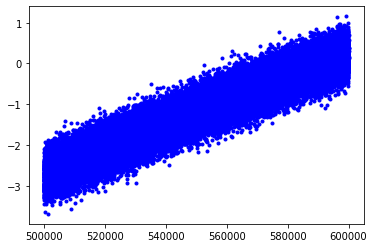

In [7]:
plt.plot(tmp.signal, ".b")

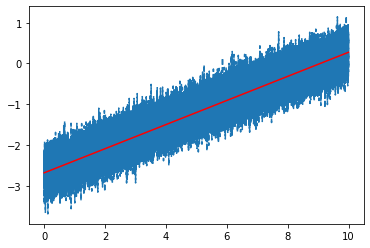

In [8]:
X = np.array(tmp["local_time"]).reshape([-1, 1])
y = np.array(tmp["signal"]).reshape([-1, 1])

reg = LinearRegression().fit(X, y)

slope, intercept = reg.coef_[0][0], reg.intercept_[0]
y_fit = [slope * i + intercept for i in X[:,0]]

plt.plot(X, y, '--')
plt.plot(X, y_fit, 'r')

/home/ww6p9/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


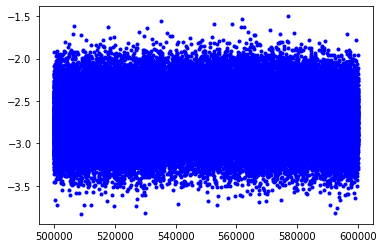

In [9]:
tmp["signal_recover"] = tmp.signal - y_fit + intercept
plt.plot(tmp.signal_recover, ".b")

### half circle

In [10]:
# half circle
tmp = train[(train.batch == 7) & (train.open_channels == 0)]

tmp.head()

,time,signal,open_channels,local_time,batch,mini_batch
3000690,300.0691,-2.4658,0,0.0691,7.0,1.0
3000691,300.0692,-2.6617,0,0.0692,7.0,1.0
3000692,300.0693,-2.7685,0,0.0693,7.0,1.0
3000693,300.0694,-3.1067,0,0.0694,7.0,1.0
3000694,300.0695,-2.7286,0,0.0695,7.0,1.0


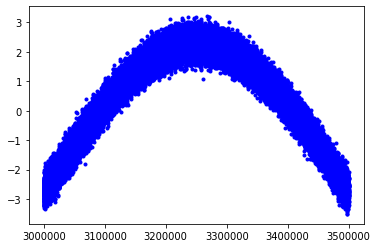

In [11]:
plt.plot(tmp.signal, ".b")

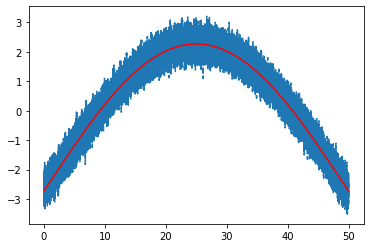

In [12]:
X = np.array(tmp["local_time"]).reshape([-1, 1])
y = np.array(tmp["signal"]).reshape([-1, 1])

polynomial_features= PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)


reg = LinearRegression().fit(x_poly, y)
y_fit = reg.predict(x_poly)

plt.plot(X, y, '--')
plt.plot(X, y_fit, 'r')

/home/ww6p9/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


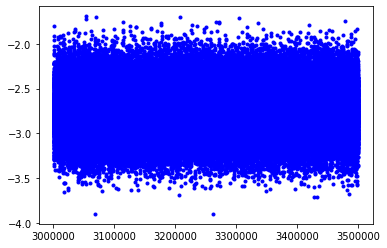

In [13]:
tmp["signal_recover"] = tmp.signal - y_fit.reshape(-1) + reg.intercept_
plt.plot(tmp.signal_recover, ".b")